In this notebook we use data scrapped from whoscored to predict the probaility of a football match to end in an away win, home in or a draw.  
The data was downloadd from this repository (link to be included).

In [1]:
import pandas as pd 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
from matplotlib import rc


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel


# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read data file

In [2]:
df = pd.read_csv('data/FootballEurope.csv') 

D:\ProgramFiles\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (38,60) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


leagues in data

In [3]:
list(df.division.unique())

['EPL', 'Bundesliga', 'Ligue_1', 'La_Liga', 'Serie_A']

seasons available in data

In [4]:
set(df.date.str[-2:])

{'12', '13', '14', '15', '16', '17'}

#### Extract all full time variables
We keep only variables/metric at full time this is because we intended to use our prediction model before the match.  
We will develop another model to predict likely winner on the half hour mark in an accompanying notebook

In [5]:
FT_variables = [col for col in df.columns if "FT" in col]

# add dividion variable for downstream seperation of analysis
FT_variables.append('division')

In [6]:
FT_result_variables = [col for col in df.columns if "GoalFT" in col]

We intend to calculate the probability of a draw, home or an away victory hence we convert the final score into a categorical variable with  
- 0 => home victory
- 1 => draw
- 2 => away victory

In [7]:
df = df[FT_variables]

In [8]:
# create categorical variables for match result
df.loc[df.homeGoalFT - df.awayGoalFT > 0, 'FTR'] = 0
df.loc[df.homeGoalFT - df.awayGoalFT == 0, 'FTR'] = 1 
df.loc[df.homeGoalFT - df.awayGoalFT < 0, 'FTR'] = 2

df.FTR  = df.FTR.astype(int)
FT_result_variables.append('FTR')

# calculate total goals scored in the match
df['FTG'] = df.homeGoalFT + df.awayGoalFT
FT_result_variables.append('FTG')

In [9]:
df[FT_result_variables].head()

,homeGoalFT,awayGoalFT,FTR,FTG
0,4,1,0,5
1,1,1,1,2
2,5,5,1,10
3,2,1,0,3
4,2,1,0,3


In [10]:
goals_variables = ['homeGoalFT', 'awayGoalFT', 'FTG']
df.drop(goals_variables, axis=1, inplace=True)

#### check away vs home vs draw across divisions.  
We observe fairly similar distibution for wins and draws across all five divisions

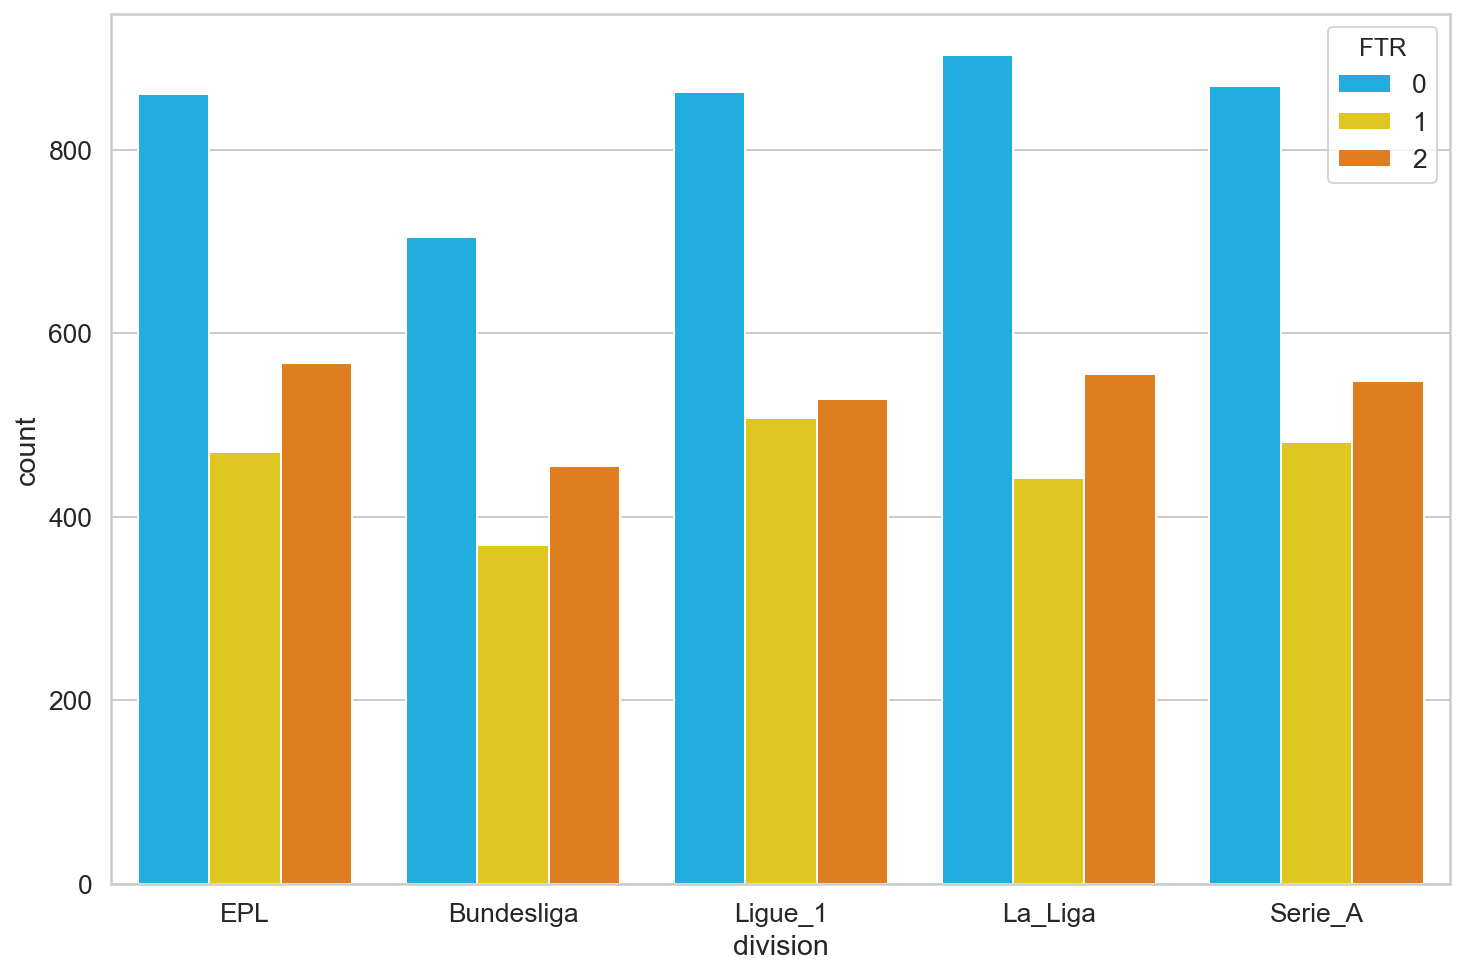

In [11]:
ax = sns.countplot(x="division", hue="FTR", data=df)

## EDA

In [12]:
#Select all numeric variables
independent_vars = [col for col in df.columns if col not in FT_result_variables + ['division']]

independent_vars_home = [col for col in independent_vars if 'home' in col]
independent_vars_away = [col for col in independent_vars if 'away' in col]

In [13]:
print("Number of independent variables {}.".format(len(independent_vars)))
print("Number of independent variables for home team {}.".format(len(independent_vars_home)))
print("Number of independent variables for away team {}.".format(len(independent_vars_away)))

Number of independent variables 38.
Number of independent variables for home team 19.
Number of independent variables for away team 19.


In [14]:
df[independent_vars].describe()

,awayDispossessedFT,awayPassSuccessFT,awayRatingsFT,awayDribbleSuccessFT,homeFoulsCommitedFT,homeAerialsTotalFT,awayShotsOnTargetFT,awayShotsBlockedFT,homePassesKeyFT,awayDribblesWonFT,...,homeTacklesTotalFT,homeOffsidesCaughtFT,awayDribblesAttemptedFT,homeInterceptionsFT,awayTacklesTotalFT,homeRatingsFT,homeDribblesAttemptedFT,homeTackleSuccessFT,awayPossessionFT,awayShotsTotalFT
count,9126.000000,9127.000000,9127.000000,9125.000000,9127.000000,9127.000000,9069.000000,8906.000000,9127.000000,9125.000000,...,9127.000000,8860.000000,9127.000000,9127.000000,9127.000000,9127.000000,9126.000000,9127.000000,9127.000000,9126.000000
mean,11.542735,66.551030,6.439506,51.522129,13.423688,35.085022,3.927555,2.684258,10.374493,8.817205,...,28.222307,2.515801,16.700778,16.291553,29.178810,6.513104,17.774381,71.066465,38.885950,11.294872
std,4.596256,8.826947,0.214911,17.167074,4.330811,13.962922,2.242898,1.939921,4.356334,4.537354,...,8.254193,1.843057,6.774650,6.065943,8.365003,0.216431,6.948109,11.226337,20.675034,4.575210
min,0.000000,0.000000,5.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.670000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,60.675000,6.300000,40.000000,10.000000,25.000000,2.000000,1.000000,7.000000,6.000000,...,23.000000,1.000000,12.000000,12.000000,23.000000,6.370000,13.000000,63.790000,35.410000,8.000000
50%,11.000000,66.890000,6.430000,50.000000,13.000000,33.000000,4.000000,2.000000,10.000000,8.000000,...,28.000000,2.000000,16.000000,16.000000,29.000000,6.500000,17.000000,71.590000,45.590000,11.000000
75%,14.000000,72.875000,6.570000,62.500000,16.000000,43.000000,5.000000,4.000000,13.000000,11.000000,...,33.000000,4.000000,21.000000,20.000000,34.000000,6.650000,22.000000,78.690000,52.710000,14.000000
max,36.000000,91.730000,7.410000,100.000000,33.000000,118.000000,15.000000,13.000000,36.000000,44.000000,...,74.000000,14.000000,62.000000,45.000000,77.000000,7.530000,51.000000,100.000000,79.320000,35.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   awayDispossessedFT       9126 non-null   float64
 1   awayPassSuccessFT        9127 non-null   float64
 2   awayRatingsFT            9127 non-null   float64
 3   awayDribbleSuccessFT     9125 non-null   float64
 4   homeFoulsCommitedFT      9127 non-null   int64  
 5   homeAerialsTotalFT       9127 non-null   int64  
 6   awayShotsOnTargetFT      9069 non-null   float64
 7   awayShotsBlockedFT       8906 non-null   float64
 8   homePassesKeyFT          9127 non-null   int64  
 9   awayDribblesWonFT        9125 non-null   float64
 10  homeCornersTotalFT       9103 non-null   float64
 11  homeShotsBlockedFT       9020 non-null   float64
 12  homeDribbleSuccessFT     9124 non-null   float64
 13  awayAerialsTotalFT       9127 non-null   int64  
 14  awayPassesKeyFT         

In [16]:
# check if there are any missin values
print(df.isnull().values.any())

True


In [17]:
# check how many missing values are they
print(df.isnull().sum().sum())

1083


In [18]:
# percentage of missing
print(format(100*df.isnull().sum()/df.shape[0]))

awayDispossessedFT         0.010957
awayPassSuccessFT          0.000000
awayRatingsFT              0.000000
awayDribbleSuccessFT       0.021913
homeFoulsCommitedFT        0.000000
homeAerialsTotalFT         0.000000
awayShotsOnTargetFT        0.635477
awayShotsBlockedFT         2.421387
homePassesKeyFT            0.000000
awayDribblesWonFT          0.021913
homeCornersTotalFT         0.262956
homeShotsBlockedFT         1.172346
homeDribbleSuccessFT       0.032870
awayAerialsTotalFT         0.000000
awayPassesKeyFT            0.054783
homePossessionFT           0.000000
awayInterceptionsFT        0.000000
homeDribbledPastFT         0.021913
homeDribblesWonFT          0.032870
awayTackleSuccessFT        0.000000
homeDispossessedFT         0.000000
awayOffsidesCaughtFT       3.374603
awayDribbledPastFT         0.032870
homeShotsTotalFT           0.000000
homePassSuccessFT          0.000000
awayCornersTotalFT         0.558782
awayFoulsCommitedFT        0.000000
homeShotsOnTargetFT        0

#### boxplot for all home variables

In [19]:
list_of_axes = []
for i in range(5):
    for j in range(4):
        list_of_axes.append([i,j])

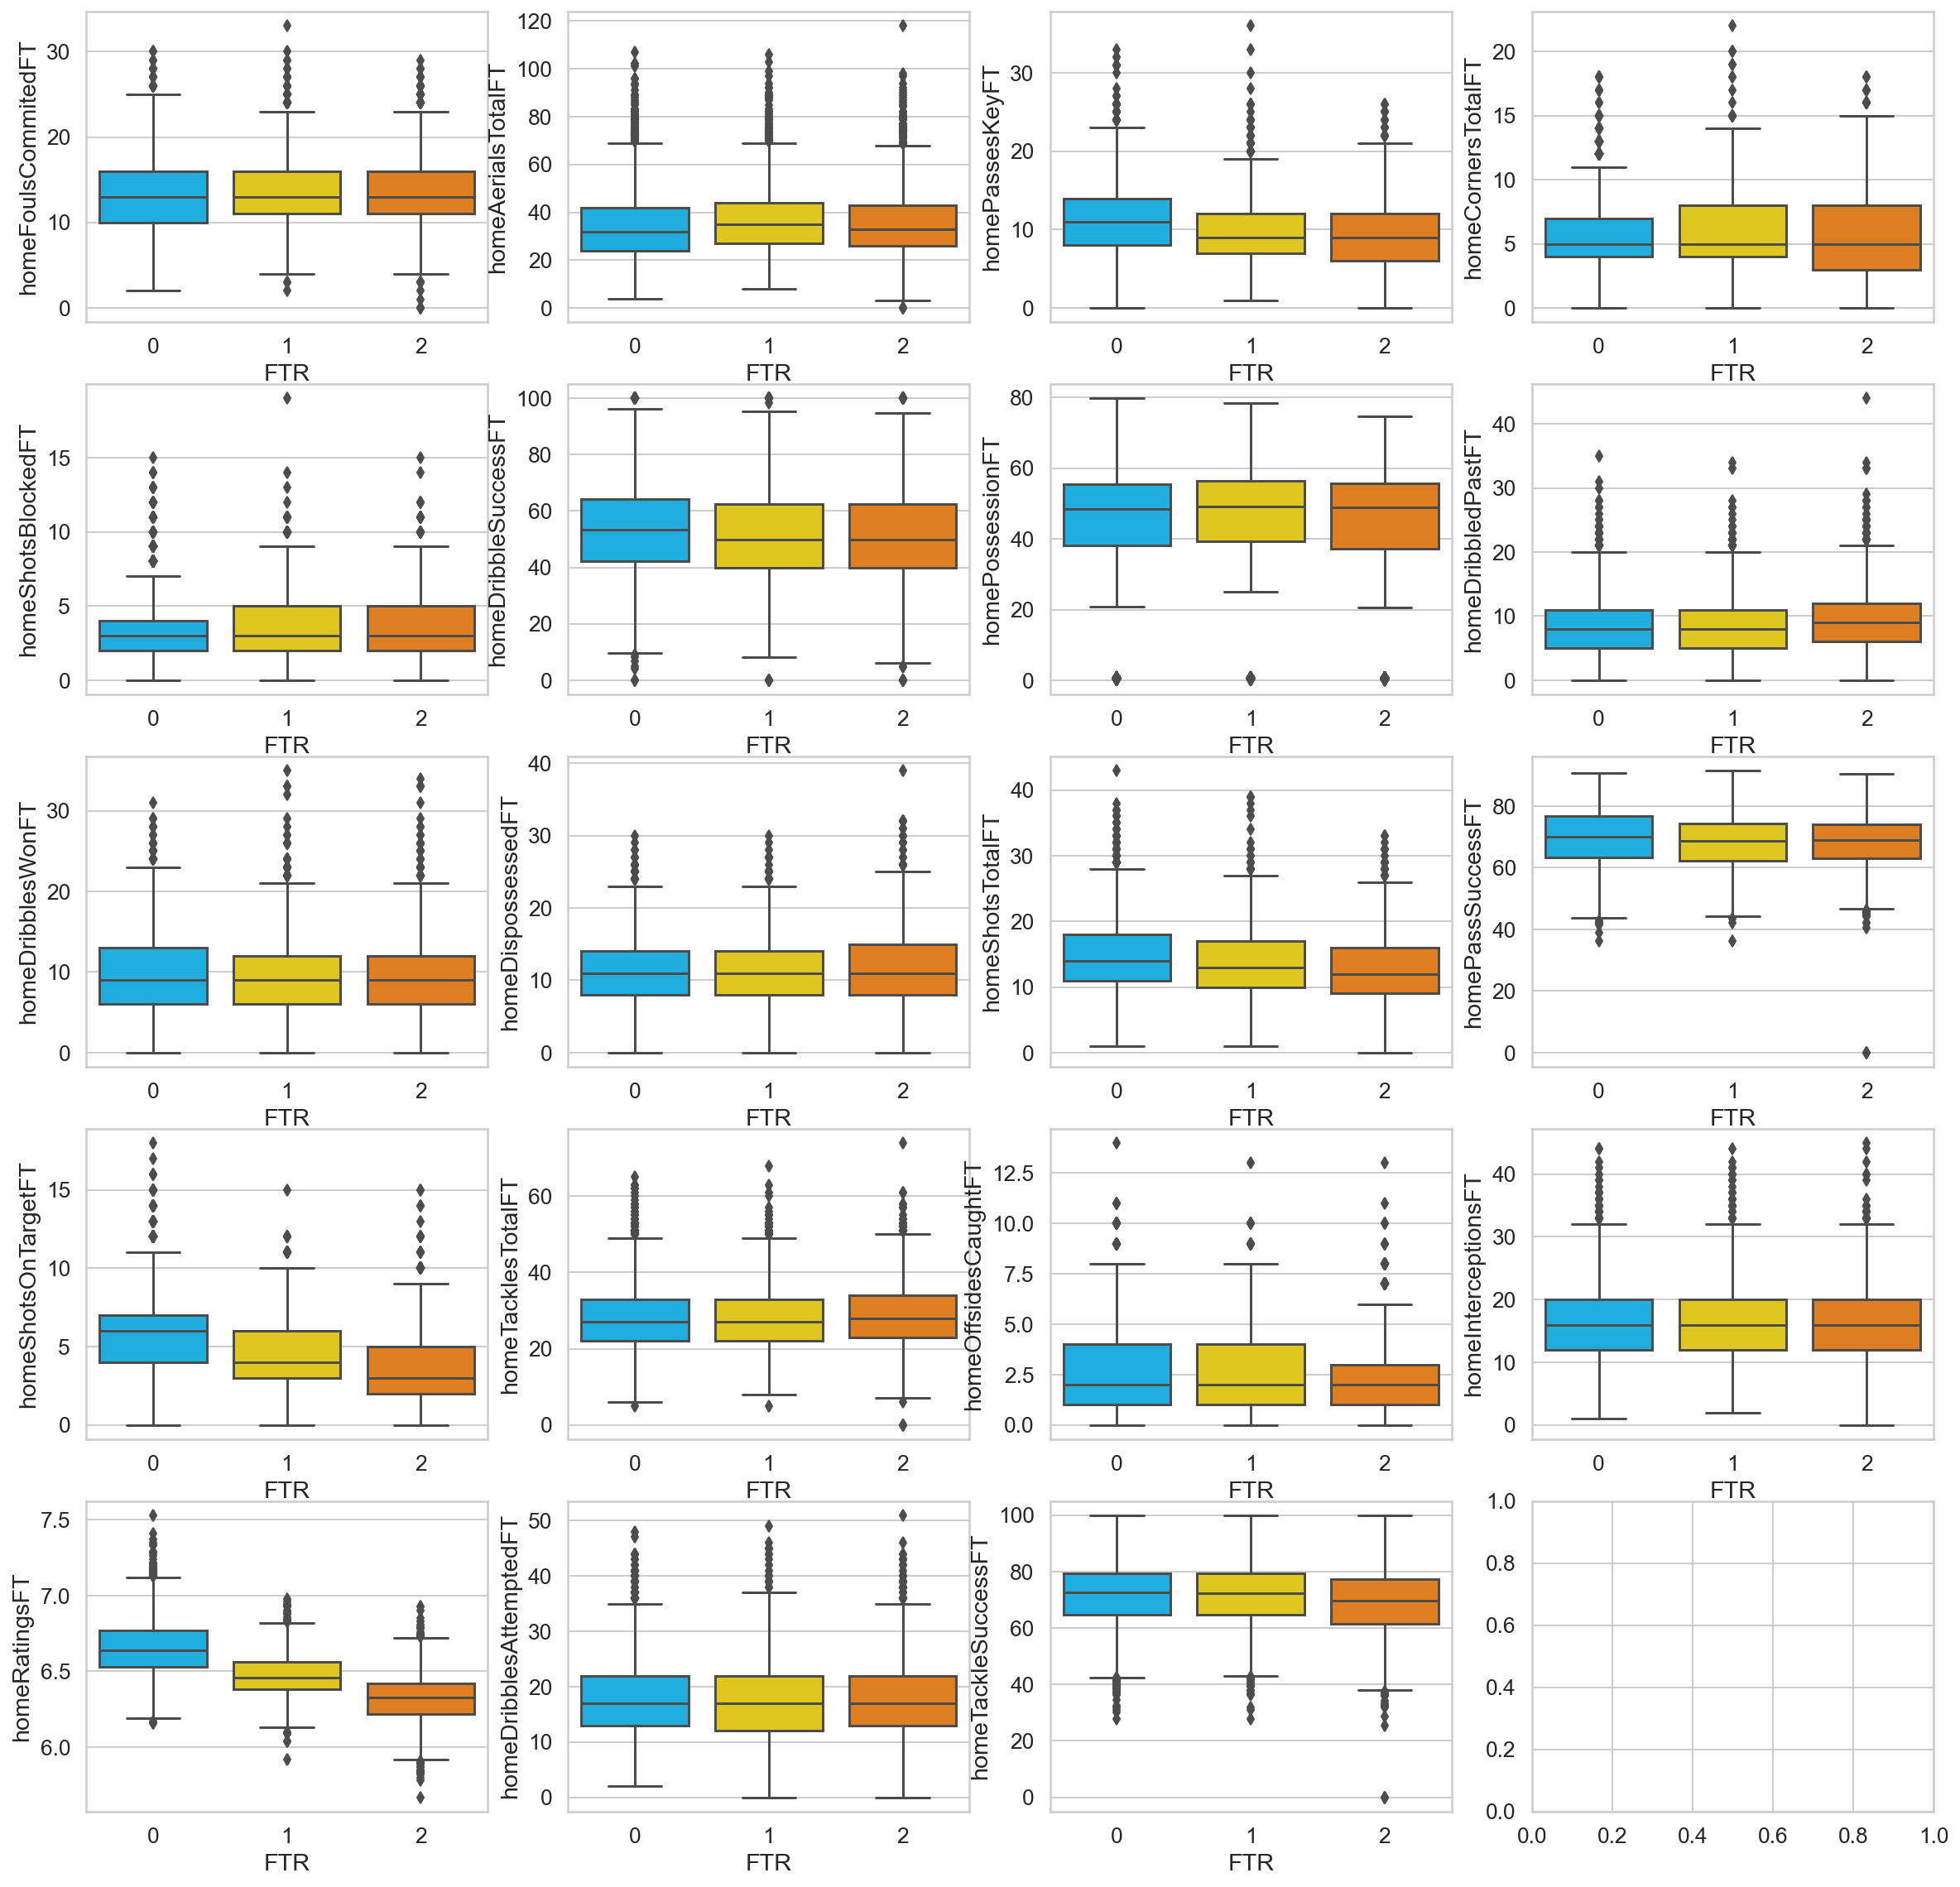

In [20]:
#, showfliers=False, width= 0.2
fig, ax = plt.subplots(5,4, figsize=(20, 20))
for i, col in enumerate(independent_vars_home):
    sns.boxplot(x=df.FTR, y=df[col], ax=ax[list_of_axes[i][0],list_of_axes[i][1]] )

#### box plots for away variables

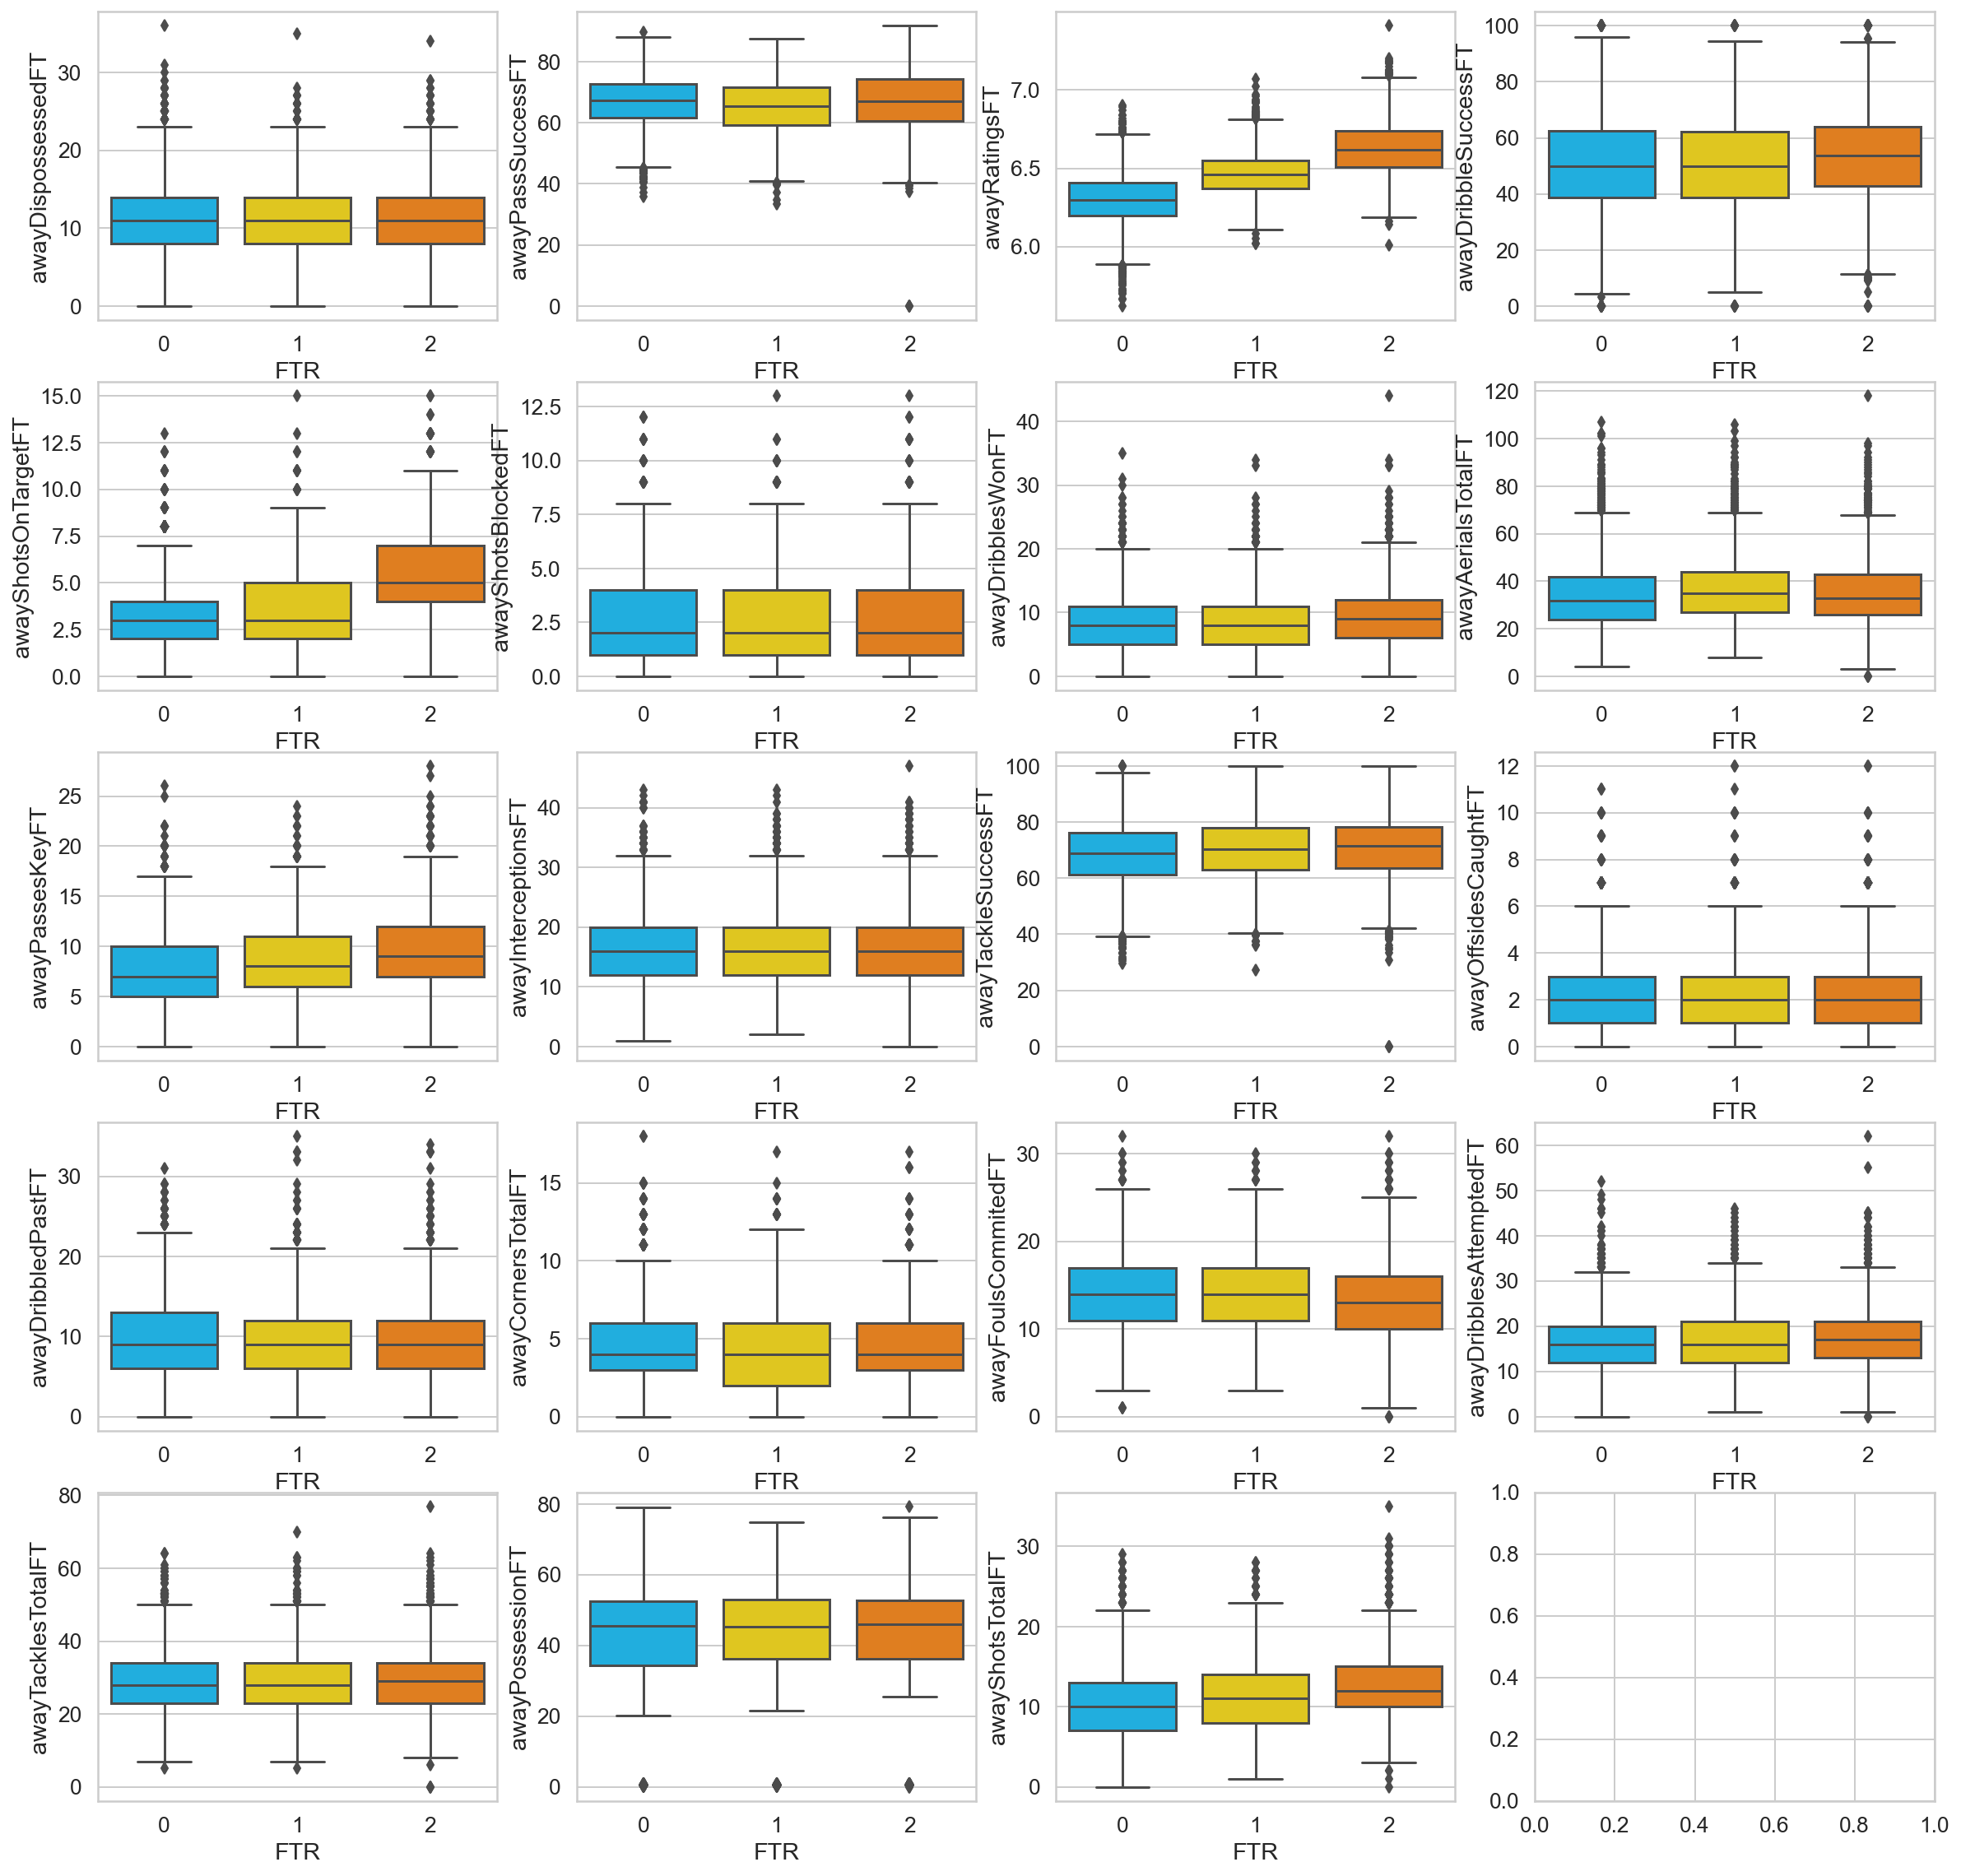

In [21]:
fig, ax = plt.subplots(5,4, figsize=(20, 20))
for i, col in enumerate(independent_vars_away):
    sns.boxplot(x=df.FTR, y=df[col], ax=ax[list_of_axes[i][0],list_of_axes[i][1]] )

# Feature Engineering

### Correlation between independent variables

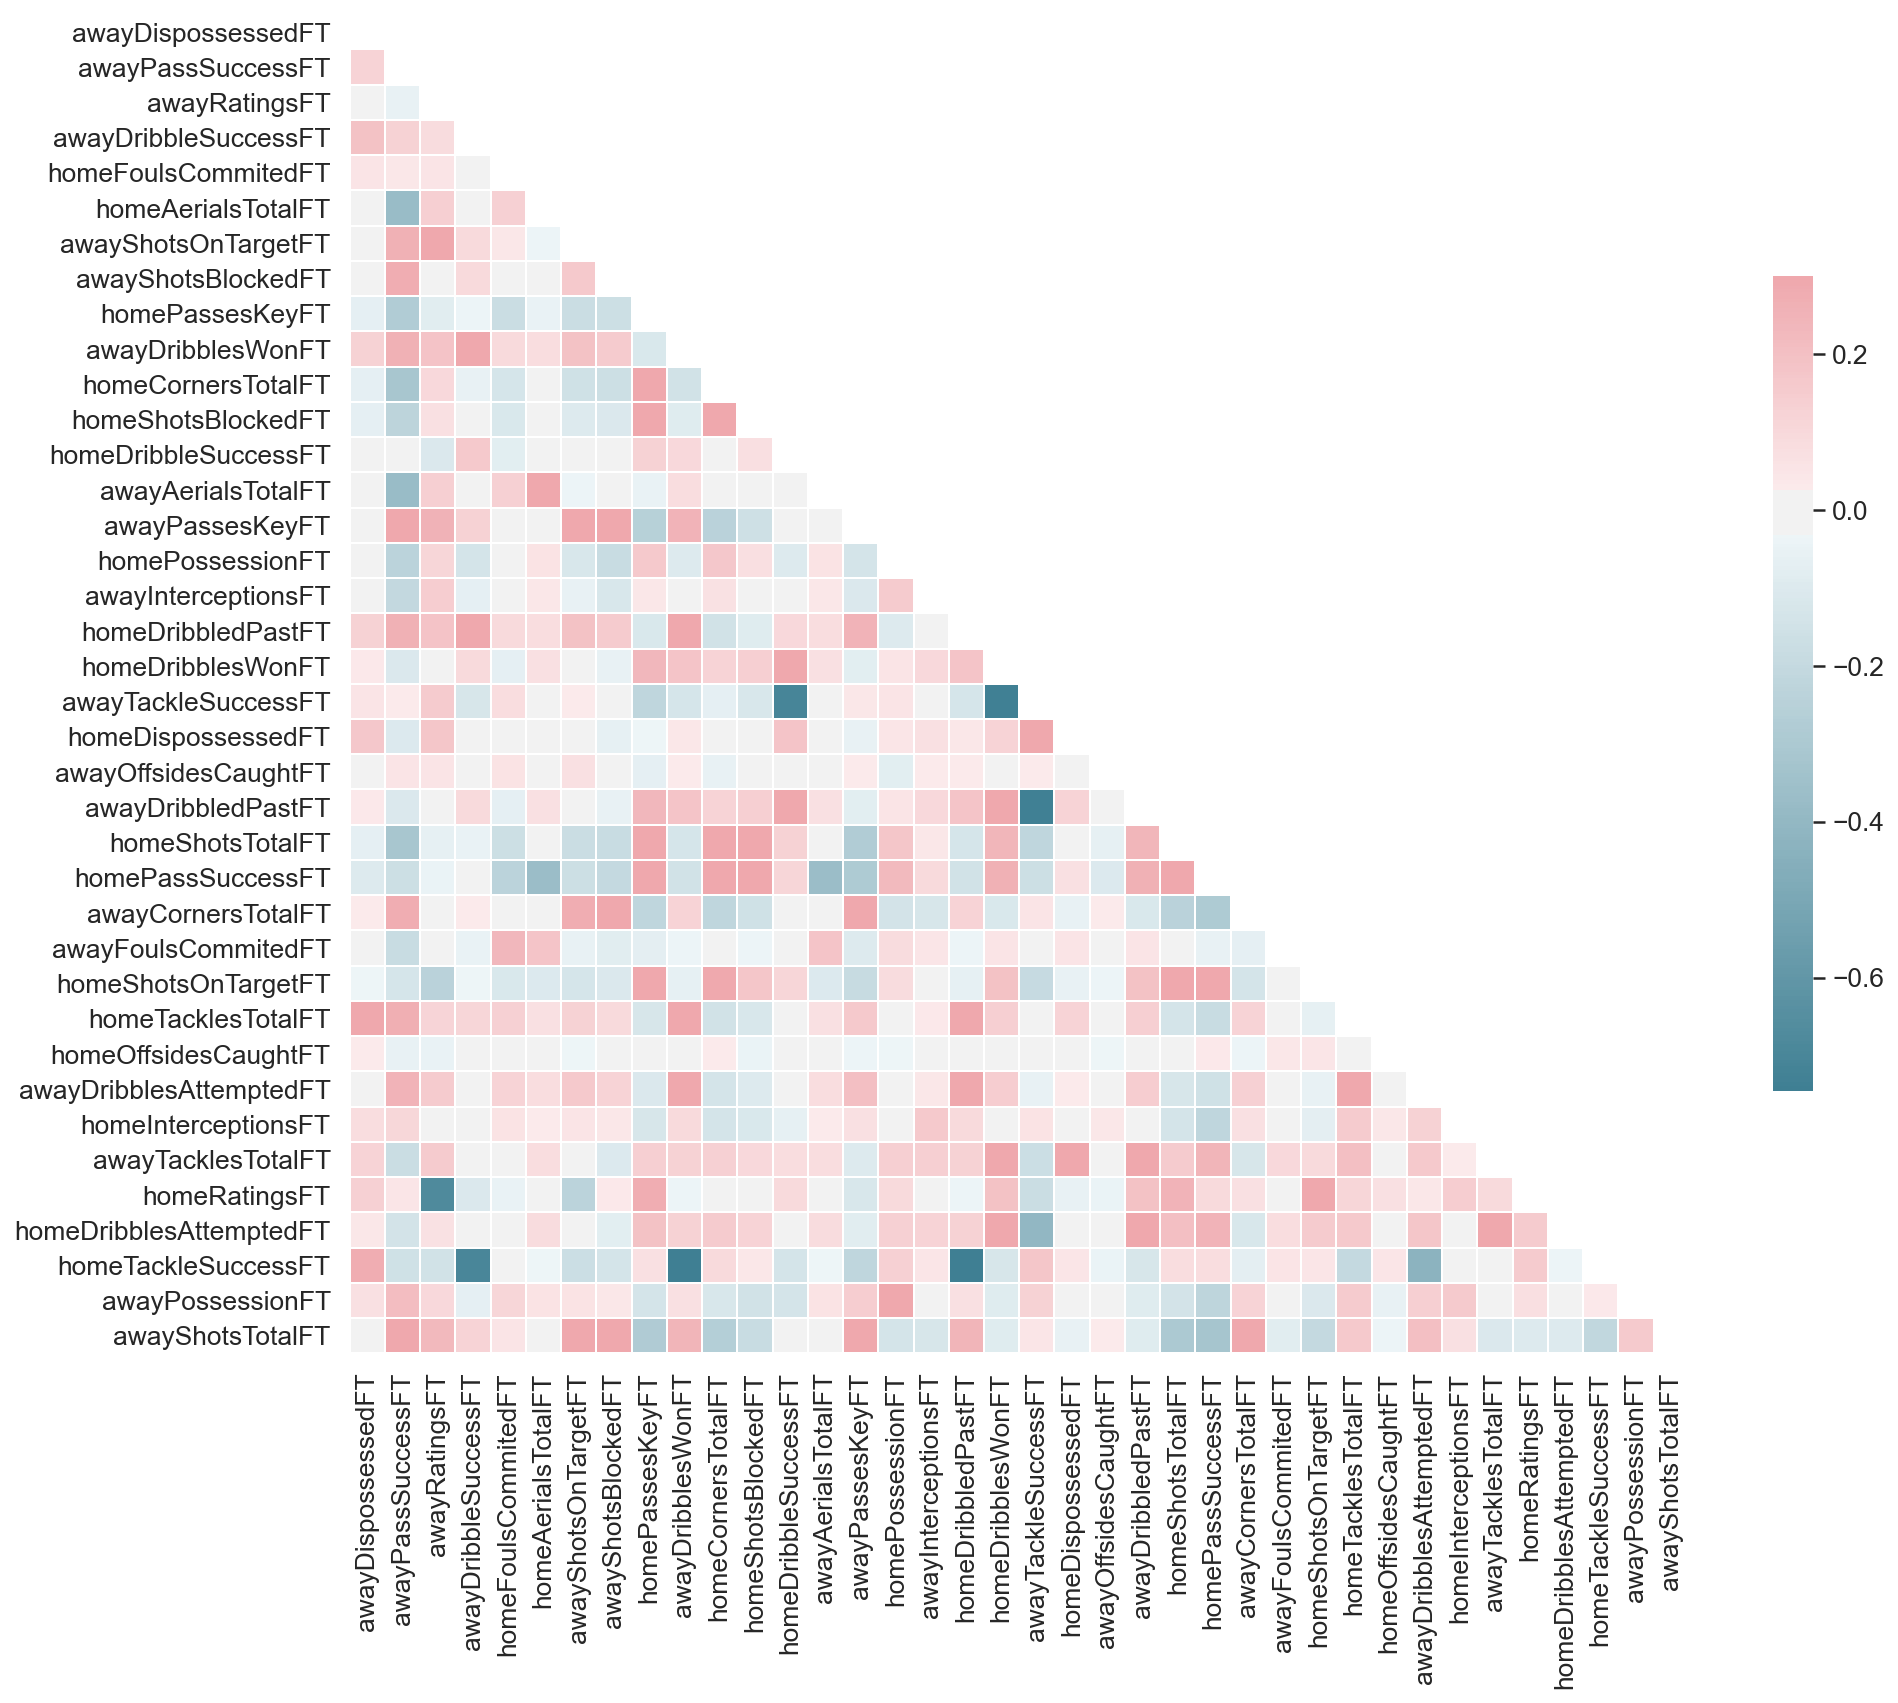

In [22]:
from string import ascii_letters

corr = df[independent_vars].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
def correlated_variables(data, corr_limit):
    
    corr = pd.DataFrame(np.triu(data.corr()))
    flat_cm = corr.stack().reset_index()
    flat_cm.columns = ['variable1', 'variable2', 'correlation']
    flat_cm.correlation = abs(flat_cm.correlation)
    
    flat_cm['variable1'] = data.columns[flat_cm['variable1']]
    flat_cm['variable2'] = data.columns[flat_cm['variable2']]
    
    flat_cm = flat_cm.loc[flat_cm.correlation < 1]
    flat_cm = flat_cm.sort_values(by='correlation', ascending=False)
    
    return flat_cm[flat_cm.correlation >= corr_limit]


In [24]:
cor_matrix = correlated_variables(df[independent_vars], 0.0)
cor_matrix.head()

,variable1,variable2,correlation
203,homeAerialsTotalFT,awayAerialsTotalFT,0.999976
706,homeDribblesWonFT,awayDribbledPastFT,0.999947
359,awayDribblesWonFT,homeDribbledPastFT,0.999936
327,homePassesKeyFT,homeShotsTotalFT,0.916782
569,awayPassesKeyFT,awayShotsTotalFT,0.912957


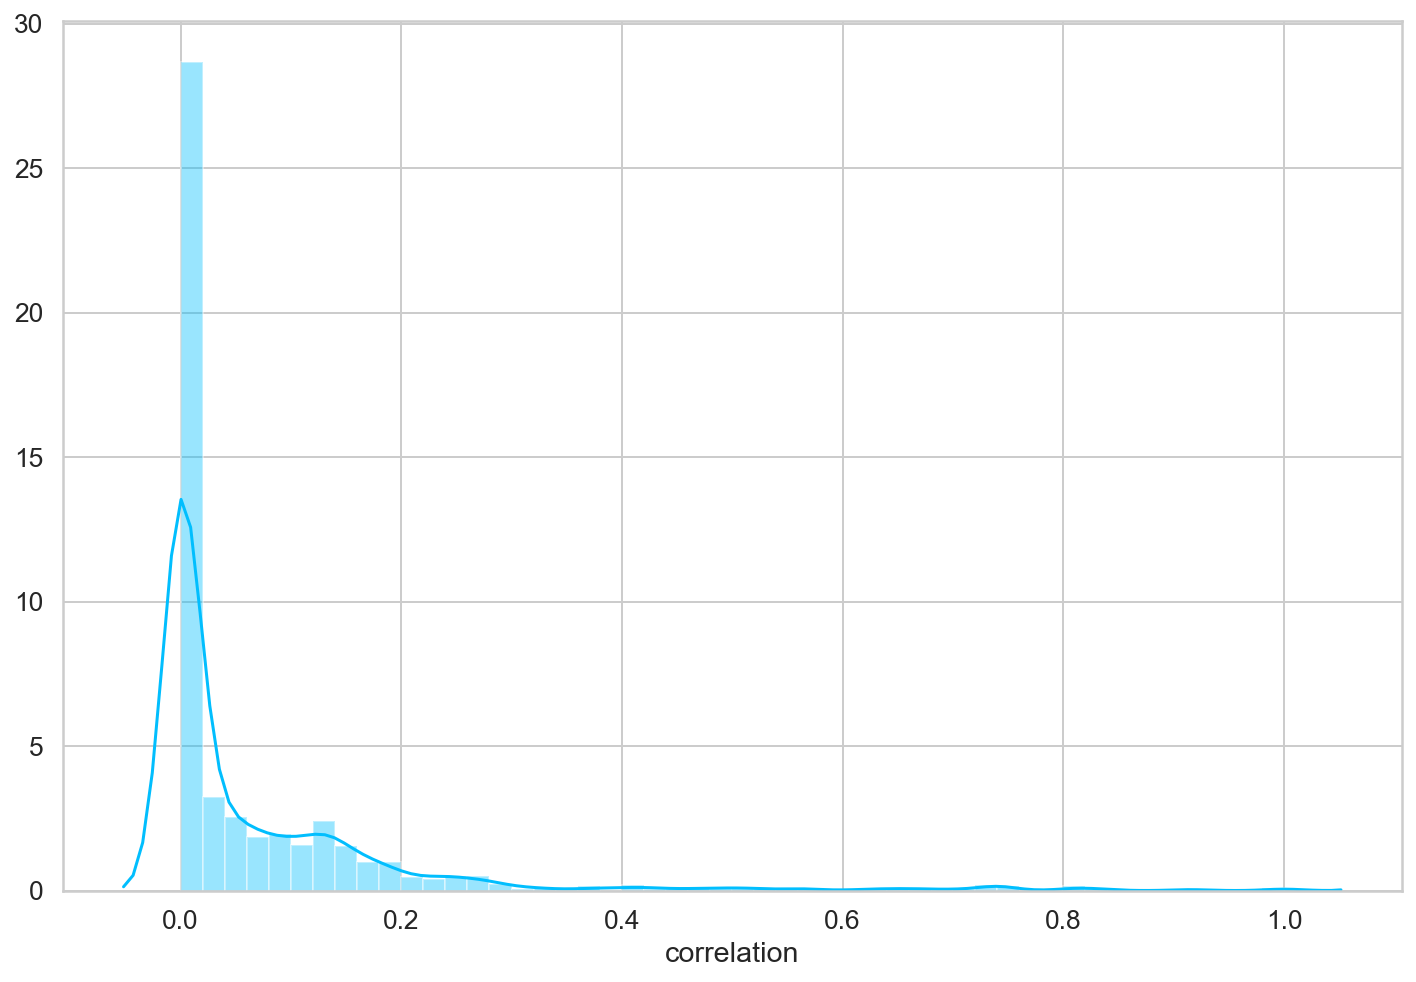

In [25]:
sns.distplot(cor_matrix.correlation)

### Univariate association to FTR

In [26]:
from scipy.stats import kruskal

def kruskal_walllis_association(df,variables):
    tmp_H = df[df.FTR == 0]
    tmp_D = df[df.FTR == 1]
    tmp_A = df[df.FTR == 2]

    pvalues = []
    for var in variables:
        stat, p = kruskal(tmp_H[var], tmp_D[var], tmp_A[var])
        pvalues.append(p)

    return pd.DataFrame({'feature':variables,'pvalue':pvalues}).sort_values(by='pvalue')


Text(0.5, 1.0, 'Features p values')

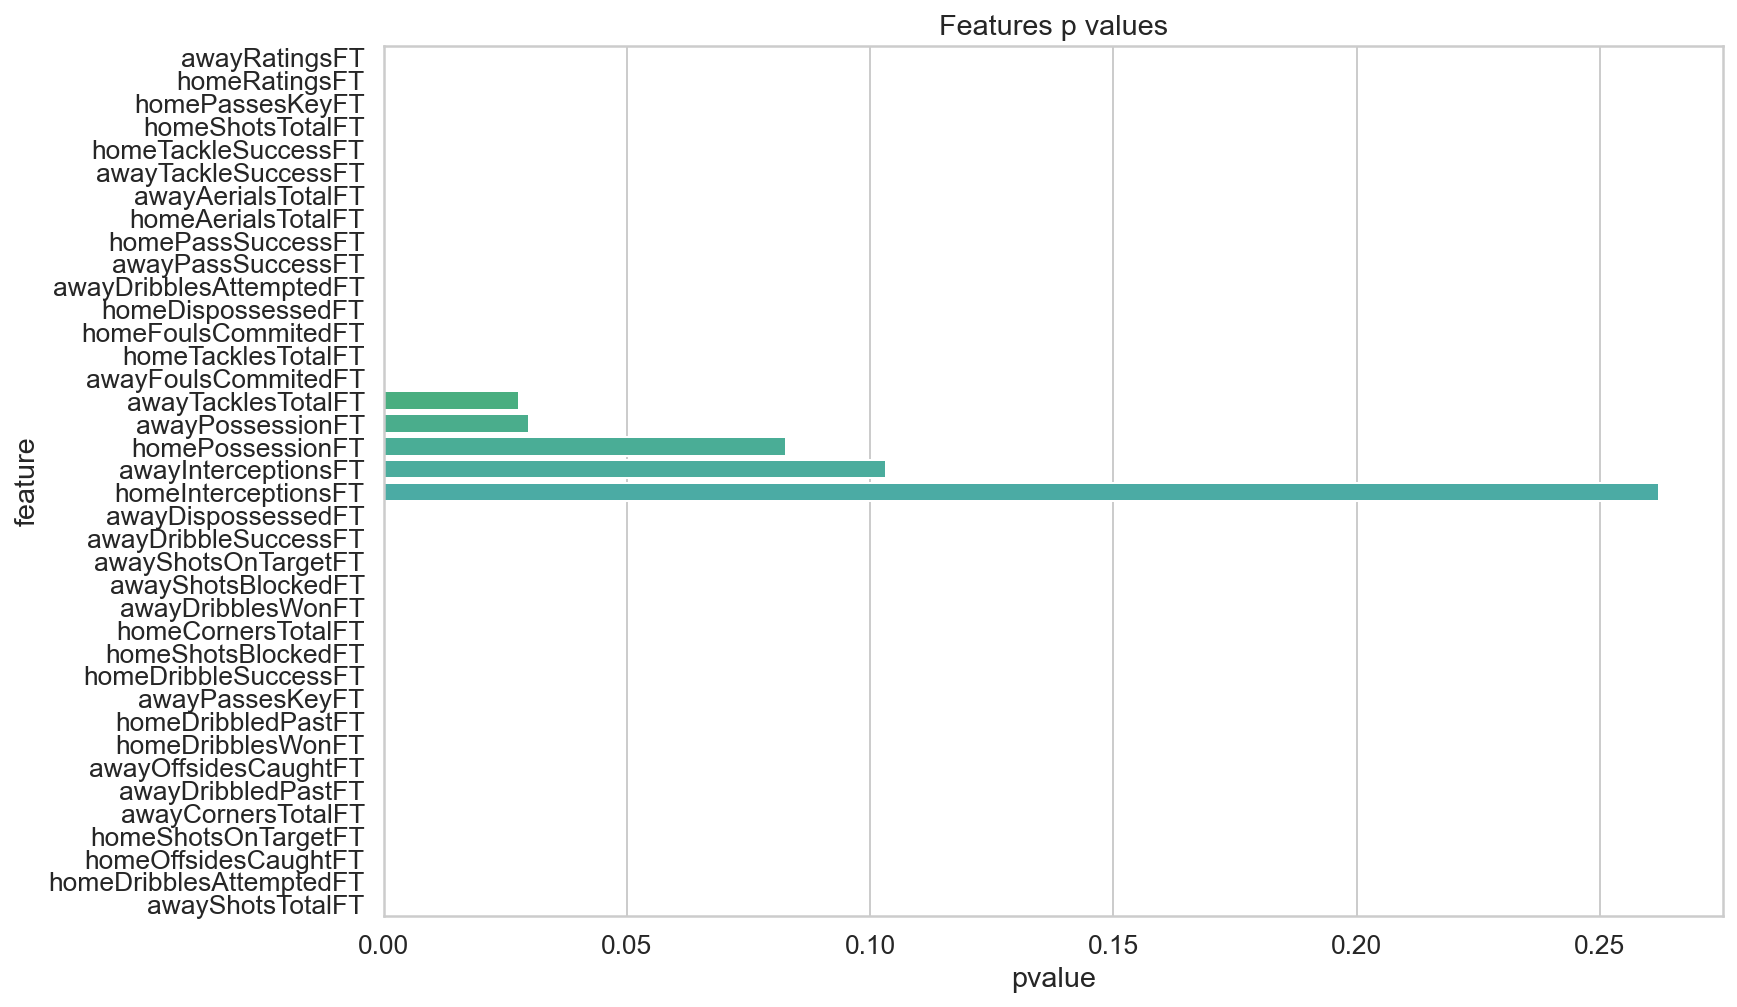

In [27]:
variable_association = kruskal_walllis_association(df, independent_vars)
#f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(x="pvalue", y="feature", data=variable_association)
plt.title('Features p values')

Looking at the association to the FTR we can observe that only home possession and interception (both home and away) are not statistically associated to the full time result of the match (pvalue > 0.05)

In [28]:
variable_association[variable_association.pvalue > 0.05]

,feature,pvalue
15,homePossessionFT,0.082777
16,awayInterceptionsFT,0.103302
31,homeInterceptionsFT,0.262184


Check statistical significant association at the individual division levels

Text(0.5, 1.0, 'Features p values')

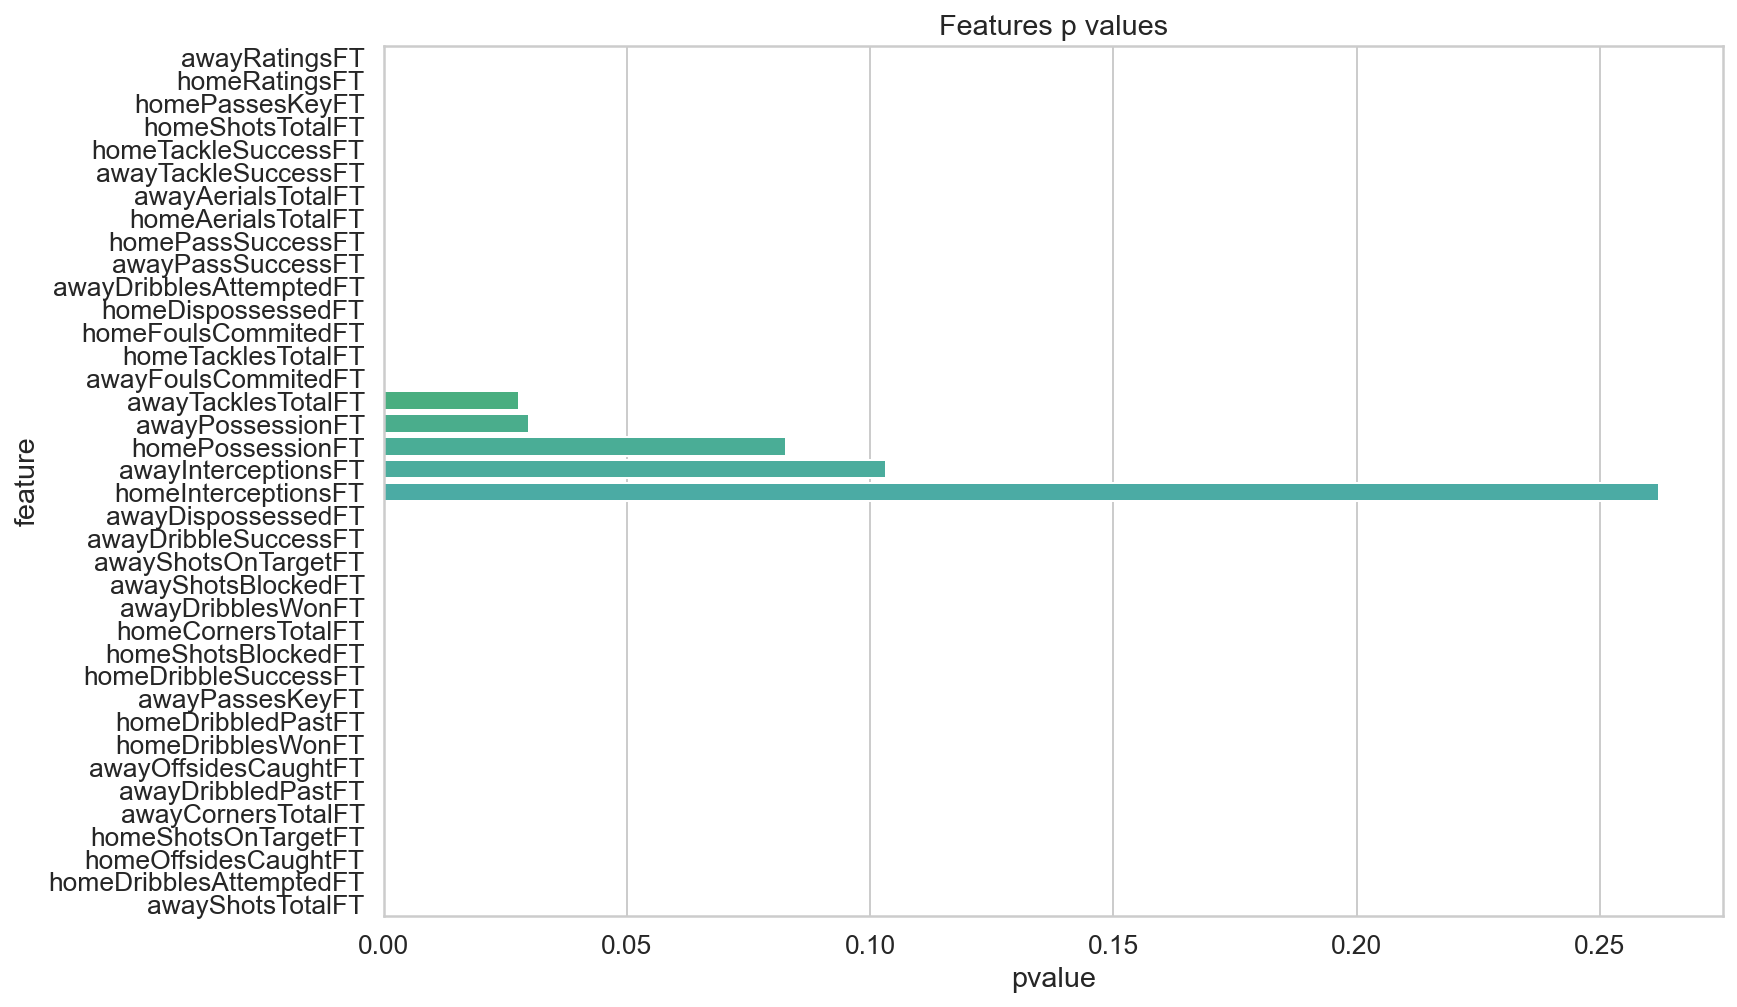

In [29]:
variable_association = kruskal_walllis_association(df, independent_vars)
#f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(x="pvalue", y="feature", data=variable_association)
plt.title('Features p values')

In [30]:
divisions = set(df.division.unique())
for i,s in enumerate(divisions):
    df_tmp = df[df.division == s]
    
    variable_association = kruskal_walllis_association(df_tmp, independent_vars)
    non_asso = variable_association[variable_association.pvalue > 0.05]
    print(s)
    print("Number of variables not associted with FTR {}".format(non_asso.shape[0]))
    print(non_asso.feature.to_list())
    print()


Bundesliga
Number of variables not associted with FTR 11
['homeDribbleSuccessFT', 'homeDribblesAttemptedFT', 'awayTacklesTotalFT', 'awayPassSuccessFT', 'awayDispossessedFT', 'homeInterceptionsFT', 'awayInterceptionsFT', 'awayPossessionFT', 'homeDispossessedFT', 'awayFoulsCommitedFT', 'homePossessionFT']

EPL
Number of variables not associted with FTR 11
['awayPossessionFT', 'awayInterceptionsFT', 'homeDribbleSuccessFT', 'awayTacklesTotalFT', 'homeInterceptionsFT', 'homeFoulsCommitedFT', 'homeDribblesWonFT', 'awayDribbledPastFT', 'homePossessionFT', 'awayDispossessedFT', 'homeDribblesAttemptedFT']

Serie_A
Number of variables not associted with FTR 6
['awayTacklesTotalFT', 'homeDispossessedFT', 'awayInterceptionsFT', 'awayDribblesAttemptedFT', 'awayPossessionFT', 'homeTacklesTotalFT']

Ligue_1
Number of variables not associted with FTR 14
['awayDribblesAttemptedFT', 'homePassSuccessFT', 'awayDribbleSuccessFT', 'homeDribblesWonFT', 'awayDribbledPastFT', 'awayDispossessedFT', 'homeDribble

#### Check preliminary variable importance per division

In [31]:
# def show_confusion_matrix(confusion_matrix):

#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True result')
#     plt.xlabel('Predicted result');

# cm = confusion_matrix(y_test, y_pred)
# df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
# show_confusion_matrix(df_cm)

the top 5 variables to predict probability of winning is similar across all 5 leagues

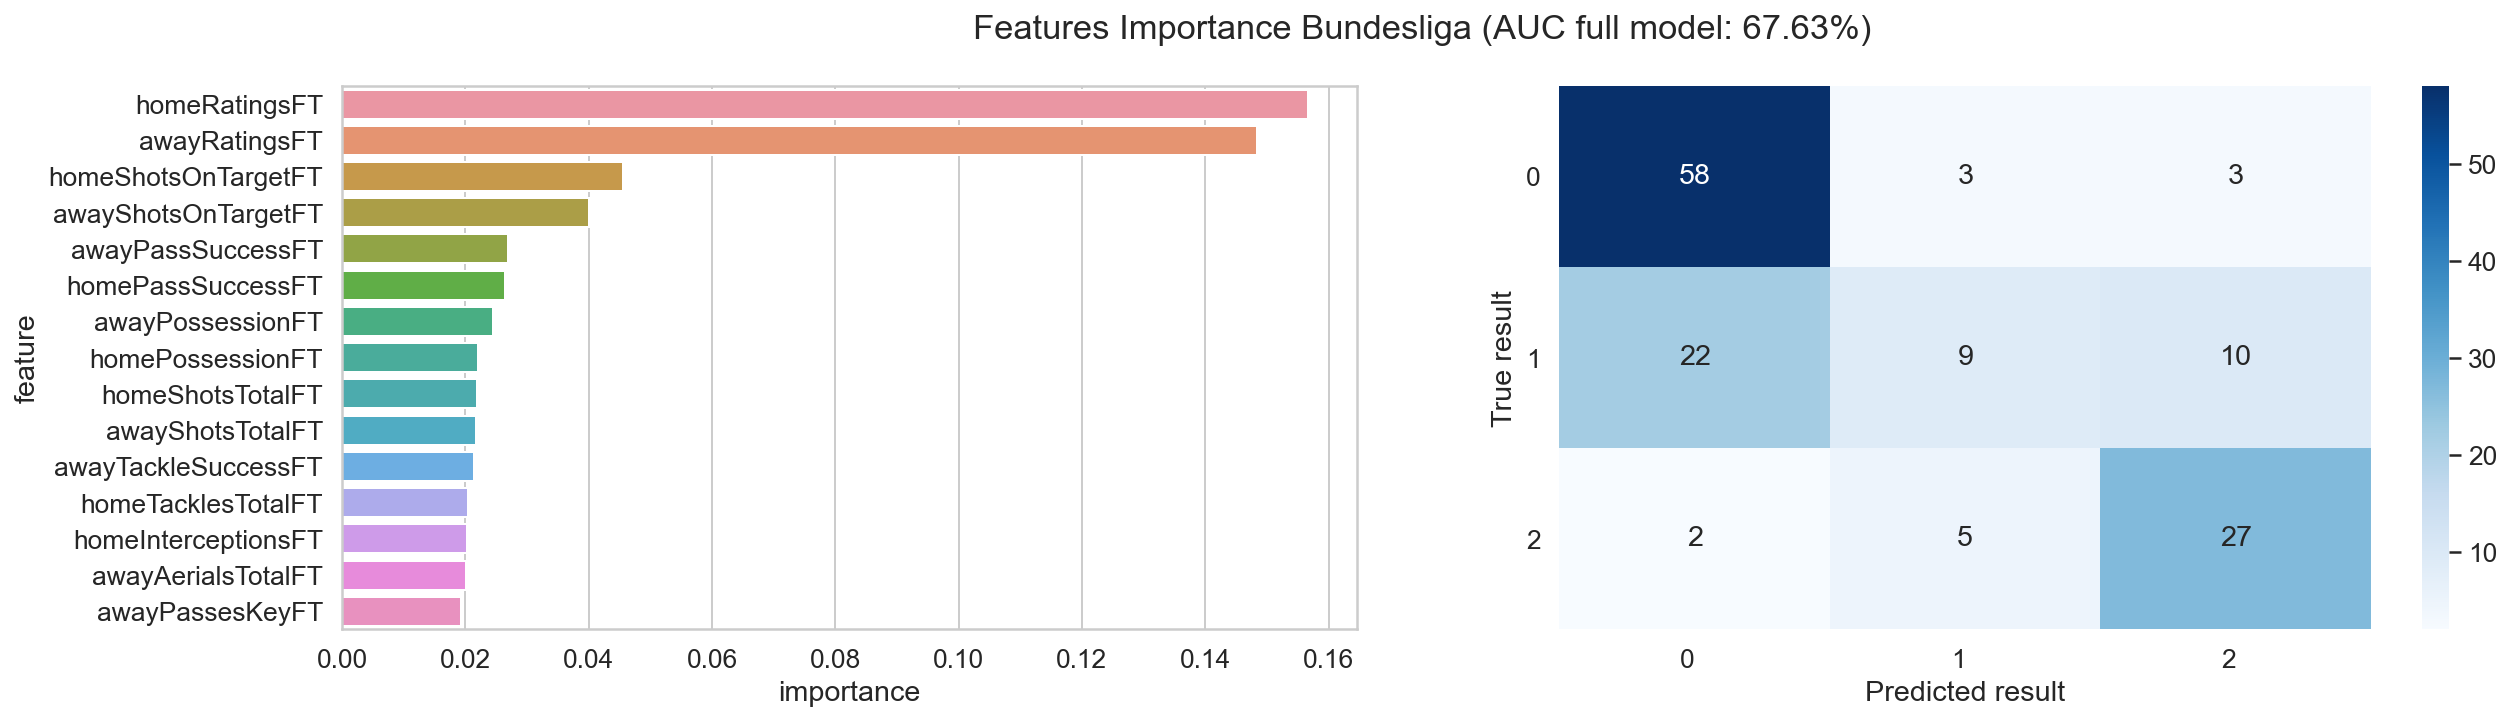

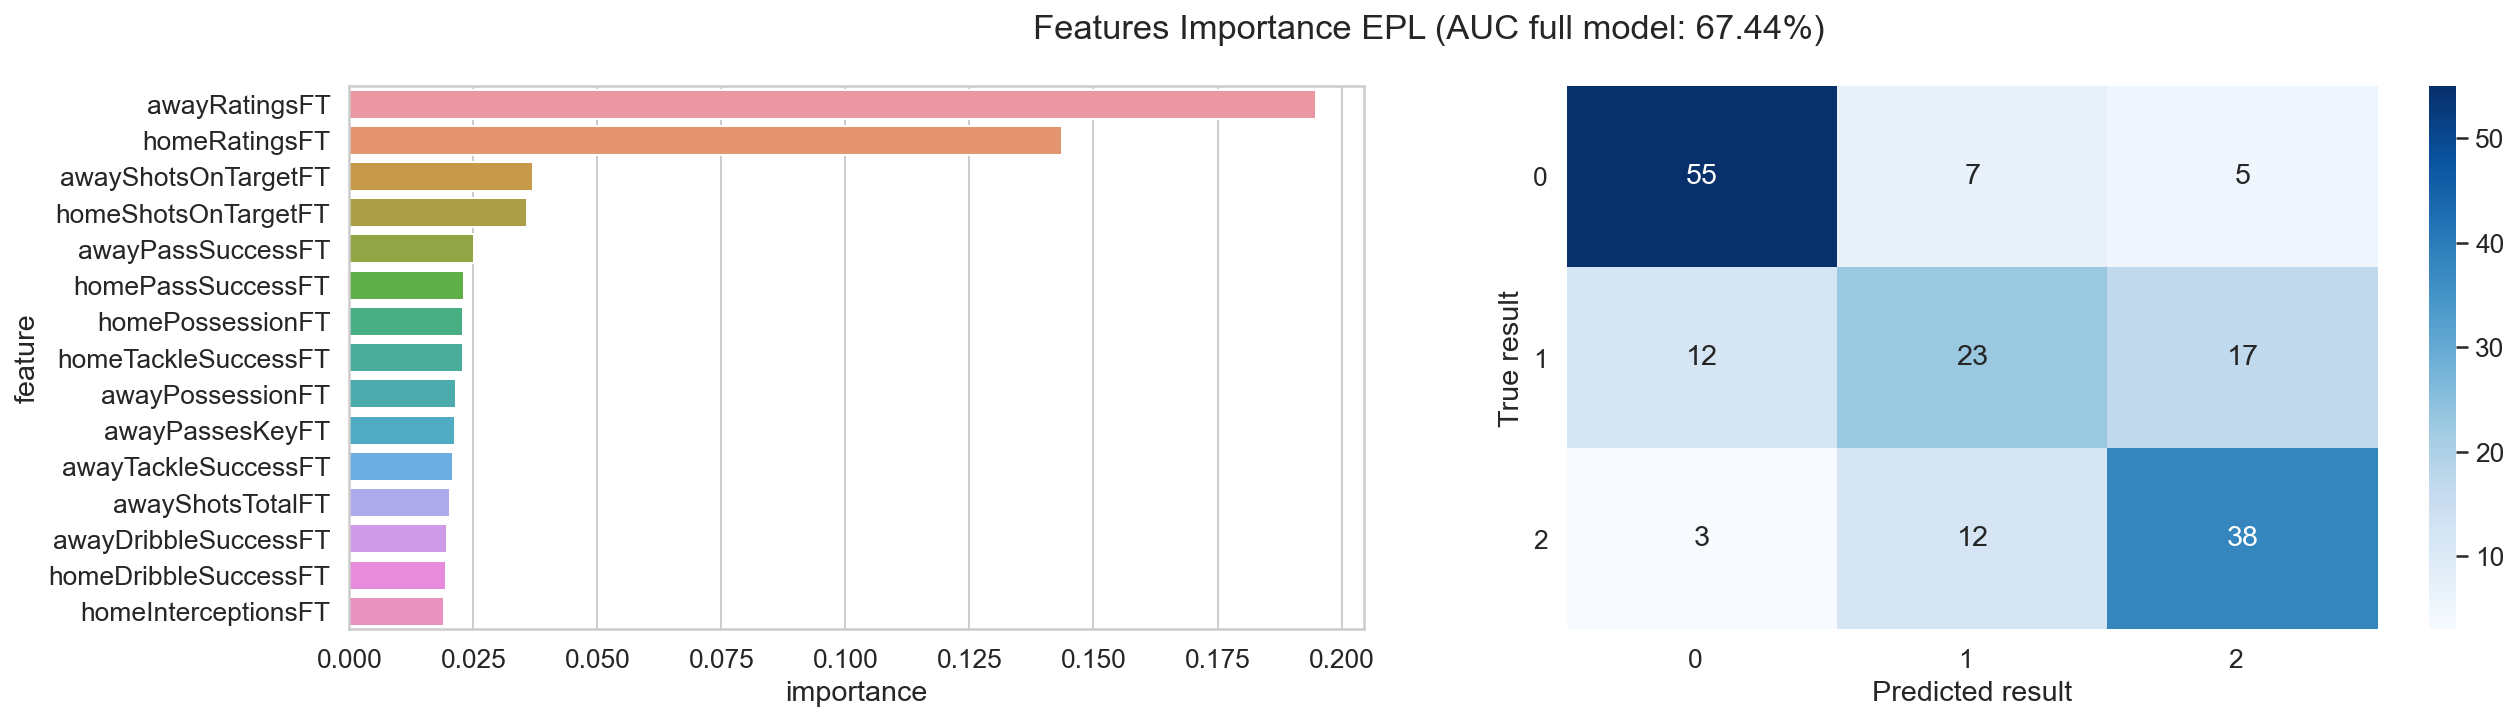

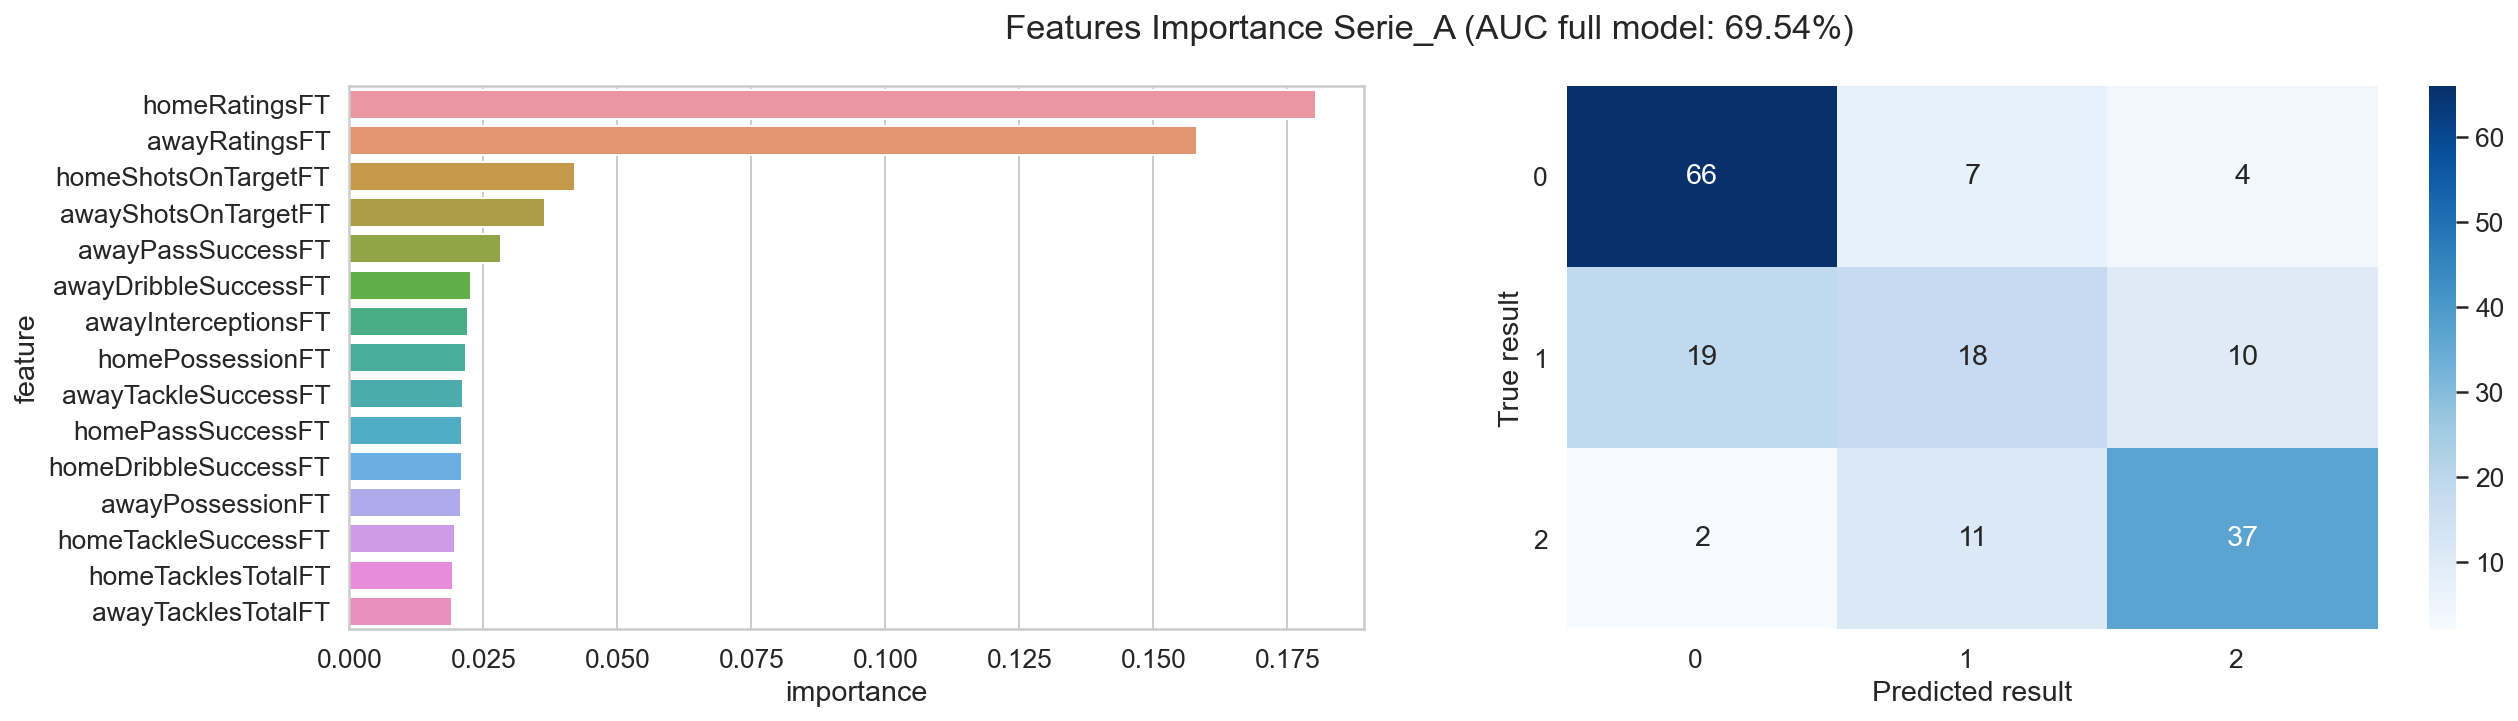

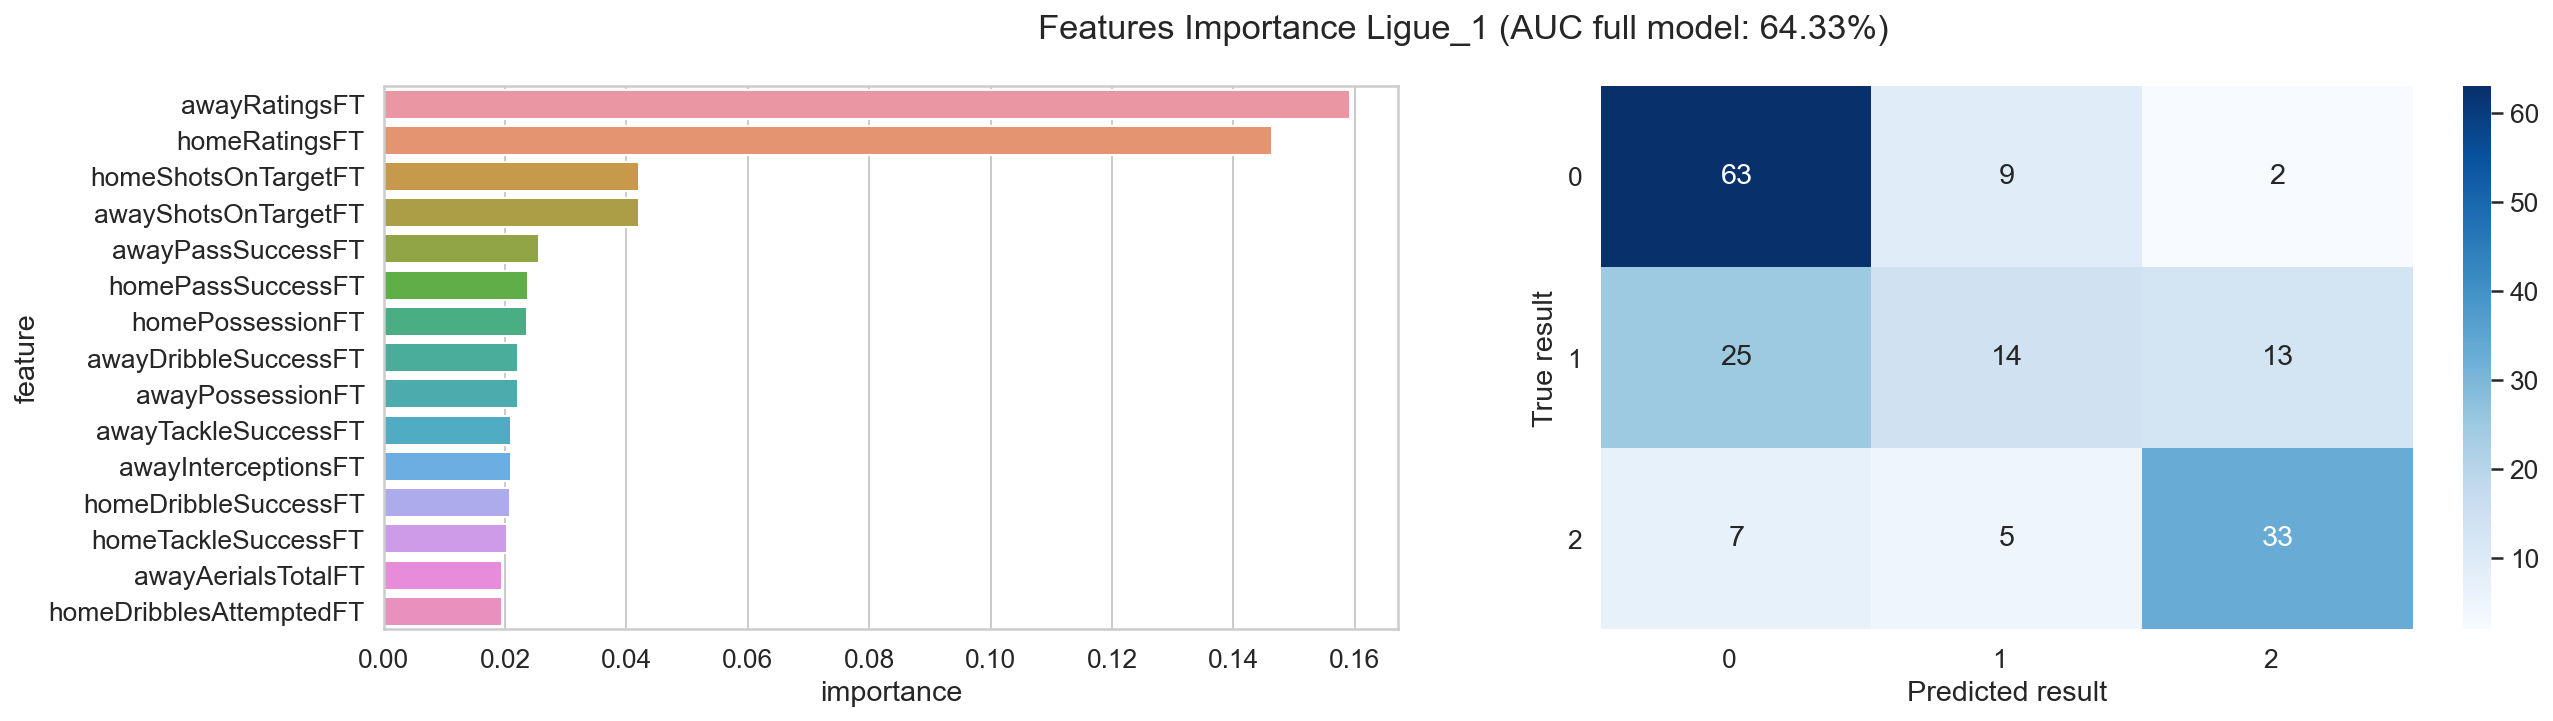

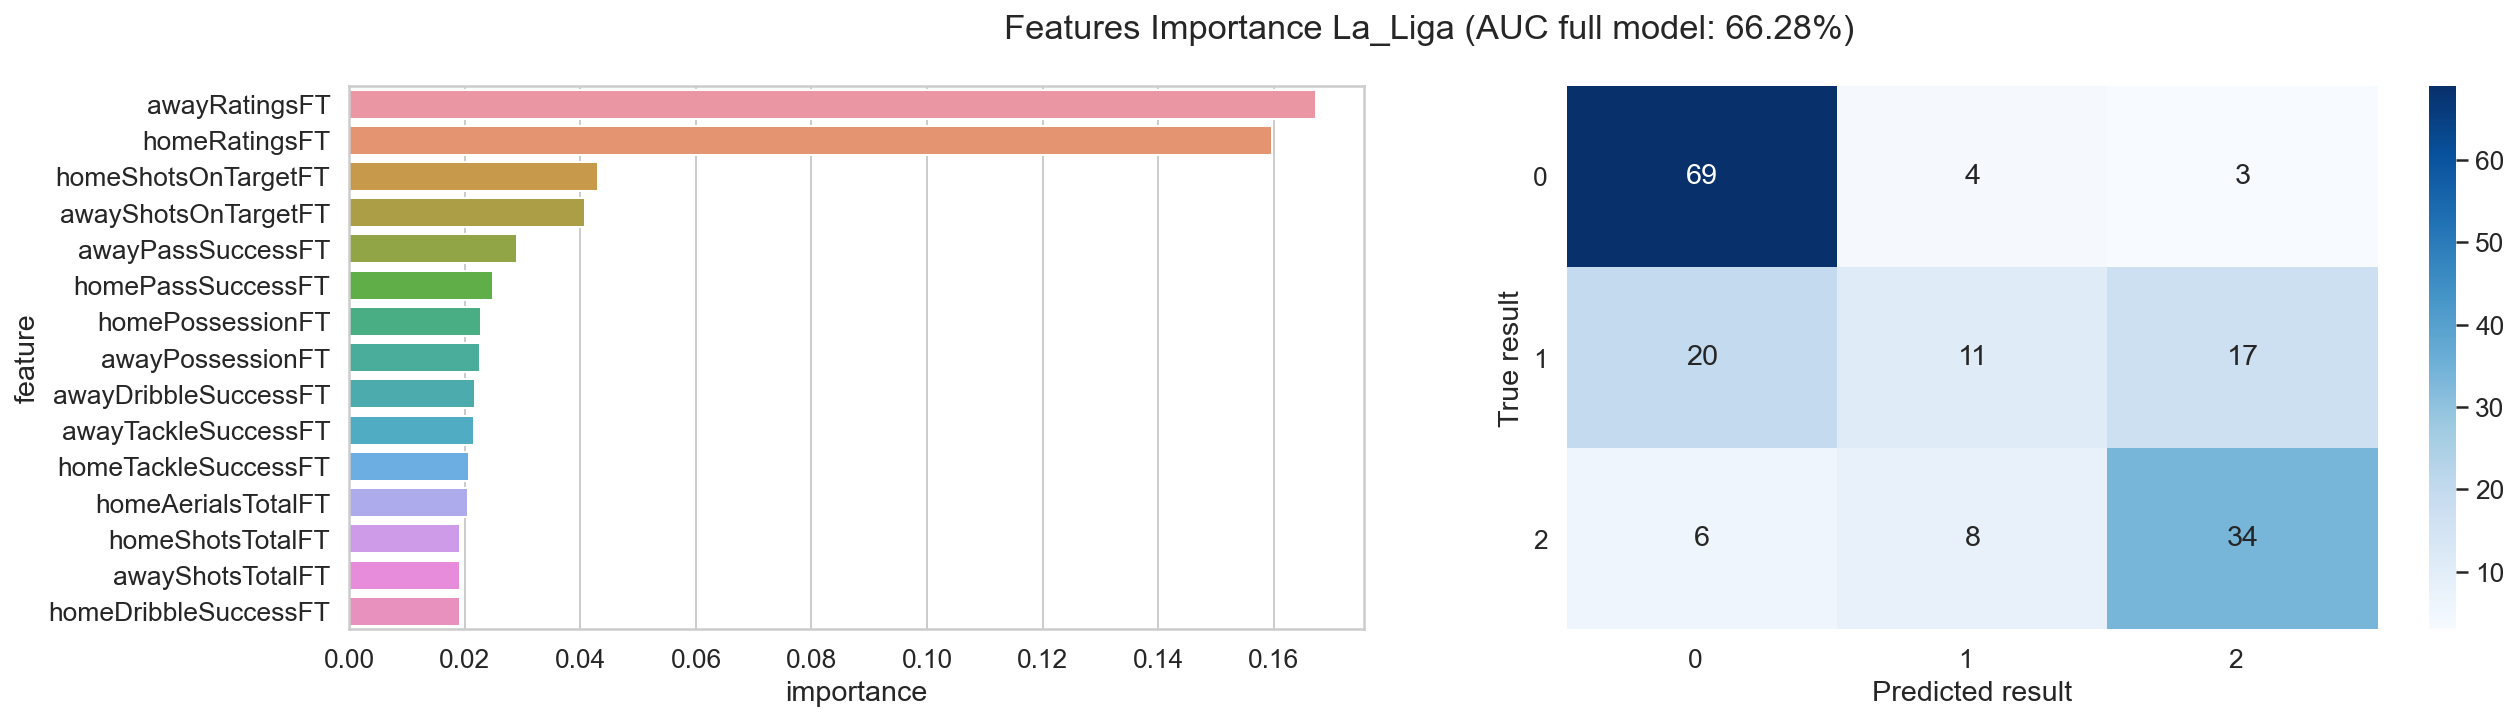

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

for div in divisions:

    data = df[df.division == div]
    data_train = data.dropna()
    response_var = 'FTR'
    response = data_train[response_var]
    data_train = data_train[independent_vars]

    x_train, x_test, y_train, y_test = train_test_split(data_train, 
                                                        response, train_size=0.90,
                                                        test_size=0.1, 
                                                        random_state=12
                                                       )
    #model = XGBClassifier()
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    auc = accuracy_score(y_test, y_pred)
    
    auc_value = " (AUC full model: %.2f%%" % (auc * 100.0) + ")"
    feature_importance = pd.DataFrame({
        'feature':x_train.columns,
        'importance':model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    fig,ax = plt.subplots(1,2, figsize=(20,5))
    sns.barplot(x="importance", y="feature", data=feature_importance.head(15), ax=ax[0])
    # generate confusion matrix
    class_names = set(df.FTR.unique())
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues" , ax=ax[1])
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    plt.ylabel('True result')
    plt.xlabel('Predicted result')
    fig.suptitle('Features Importance ' + div + auc_value)

    print()

### Split train/test/validation sets

In [33]:
response = ['FTR']
variables = independent_vars + response
# data = df[variables]

df_train, df_test = train_test_split(df, test_size=0.1, random_state=12, stratify=df['FTR'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=12, stratify=df_test['FTR'])

In [34]:
X = df_train[independent_vars].values
y = df_train[response].values.reshape((-1))

X_val = df_val[independent_vars].values
y_val = df_val[response].values.reshape((-1))

### Genetic algorithm feature selection

#### Custom

In [35]:
# from utils.algorithm import GeneticFS

# gbm = XGBClassifier()
# gfs = GeneticFS()

# # fit the optimizer
# gfs.fit(model=gbm, _type='classification', X=X, y=y) # classification model

# # get results output
# binary_output_of_optimal_variables, indicies_of_optimal_variables = gfs.results()

# # plot results of progress
# gfs.plot_progress()

#### TPOT

In [36]:
# from tpot import TPOTClassifier

# tpot = TPOTClassifier(generations=5, population_size=5, verbosity=1)

# tpot.fit(X, y.reshape((-1)))
# print(tpot.score(X_val, y_val.reshape((-1))))
# tpot.export('tpot_pipeline.py')

# # Get the best model
# exctracted_best_model = tpot.fitted_pipeline_.steps[-1][1]

# print(exctracted_best_model)

### Forward feature selection

In [37]:
def feature_selection(model, feature_importances, x_train, y_train, x_test, y_test, percent_increase=1):
    
    n_features = 1
    best_threshold = 0
    default_auc = 1
    features = feature_importances.feature[:2]
    
    thresholds = feature_importances.importance
    for feat in feature_importances.feature[2:,]:
    
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(x_train)
        
        # train model
        selection_model = XGBClassifier(seed=12)
        selection_model.fit(select_X_train, y_train)
        
        # evaluate on training set
        probs_tr = selection_model.predict_proba(select_X_train)
        probs_tr = probs_tr[:, 1]
        auc_tr = 100*roc_auc_score(y_train, probs_tr)

        # eval model on test set
        select_X_test = selection.transform(x_test)
        probs = selection_model.predict_proba(select_X_test)
        probs = probs[:, 1]
        auc_test = 100*roc_auc_score(y_test, probs)

        print("Thresh=%.3f, n=%d, AUC: %.2f%%" % (thresh, select_X_train.shape[1], auc*100.0))
        
        current_percent_increase = 100*(auc - default_auc)/default_auc
        
        if current_percent_increase >= percent_increase:
        #if auc/auc_tr >= 0.95:
            default_auc = auc
            best_threshold = thresh
            n_features = select_X_train.shape[1]
            features.append(feature_importances.feature[n_features])

    best_threshold = round(best_threshold,4)
    print("Best results: ")
    print("Thresh=%.3f, n=%d, AUC: %.2f%%" % (best_threshold, n_features, default_auc))

    return features



### Custom forward model (feature selection) 

In [38]:
selected_features = {}
percent_threshold = 1

print("Include variable if it increases accuracy by at least {}%".format(percent_threshold))
for div in divisions:
    print()
    print("Processing " + div)
    
    # training set
    data_train = df_train[df_train.division == div]
    data_train = data_train.dropna()
    
    y_train = data_train[response_var].values.reshape((-1))
    X_train = data_train[independent_vars]
    
    # validation set
    data_val = df_val[df_val.division == div]
    data_val = data_val.dropna()
    
    y_val = data_val[response_var].values.reshape((-1))
    X_val = data_val[independent_vars]

    # fit model on all training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # make predictions for test data and evaluate
    y_pred = model.predict(X_val)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_val, predictions)
       
    feature_importance = pd.DataFrame({
        'feature':x_train.columns,
        'importance':model.feature_importances_
        }).sort_values(by='importance', ascending=False)
    
    # Fit model using each importance as a threshold
    previous_accuracy = 0
    thresholds = feature_importance.importance
    
    # initialize with best scoring variable
    features = [feature_importance.feature.to_list()[0]]
    for feat in feature_importance.feature[1:]:
        
        selection_model = RandomForestClassifier()
        selection_model.fit(X_train[features], y_train)
                
        # eval model
        y_pred = selection_model.predict(X_val[features])
        predictions = [round(value) for value in y_pred]
        
        current_accuracy = accuracy_score(y_val, predictions)
        
        # calculate percentage increase
        if previous_accuracy > 0:
            percent_increase = 100*(current_accuracy - previous_accuracy)/previous_accuracy
        else:
            percent_increase = 10
        
        if percent_increase >= percent_threshold:
            previous_accuracy = current_accuracy
            features.append(feat)
            
        percent_increase = 0
    
    selected_features[div] = features
    print("Best model accuracy: %.2f%%" % (previous_accuracy*100))
    print("Selected features: {}".format(features))

Include variable if it increases accuracy by at least 1%

Processing Bundesliga
Best model accuracy: 67.95%
Selected features: ['awayRatingsFT', 'homeRatingsFT', 'awayDribbleSuccessFT']

Processing EPL
Best model accuracy: 71.74%
Selected features: ['homeRatingsFT', 'awayRatingsFT', 'homeShotsOnTargetFT', 'homePassSuccessFT', 'homePossessionFT', 'homeTackleSuccessFT', 'awayPassesKeyFT', 'awayDribbleSuccessFT']

Processing Serie_A
Best model accuracy: 68.75%
Selected features: ['homeRatingsFT', 'awayRatingsFT']

Processing Ligue_1
Best model accuracy: 67.53%
Selected features: ['awayRatingsFT', 'homeRatingsFT', 'homeShotsOnTargetFT', 'awayPassSuccessFT']

Processing La_Liga
Best model accuracy: 69.23%
Selected features: ['awayRatingsFT', 'homeRatingsFT', 'homeShotsOnTargetFT', 'awayShotsOnTargetFT', 'homePossessionFT']


#### Forward selection for all divisions

In [39]:
# training set
data_train = df_train.dropna()
y_train = data_train[response_var].values.reshape((-1))
X_train = data_train[independent_vars]
    
# validation set
data_val = df_val.dropna()
y_val = data_val[response_var].values.reshape((-1))
X_val = data_val[independent_vars]

# fit model on all training data
model = RandomForestClassifier()
model.fit(X_train, y_train)
    
# make predictions for test data and evaluate
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)
       
feature_importance = pd.DataFrame({
    'feature':x_train.columns,
    'importance':model.feature_importances_
}).sort_values(by='importance', ascending=False)


thresholds = feature_importance.importance
for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_val)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_val, y_pred)
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.179, n=1, Accuracy: 62.92%
Thresh=0.152, n=2, Accuracy: 69.86%
Thresh=0.048, n=3, Accuracy: 69.38%
Thresh=0.042, n=4, Accuracy: 68.66%
Thresh=0.025, n=5, Accuracy: 69.38%
Thresh=0.024, n=6, Accuracy: 69.86%
Thresh=0.022, n=7, Accuracy: 69.86%
Thresh=0.021, n=8, Accuracy: 69.86%
Thresh=0.021, n=9, Accuracy: 70.57%
Thresh=0.021, n=10, Accuracy: 68.90%
Thresh=0.021, n=11, Accuracy: 69.38%
Thresh=0.021, n=12, Accuracy: 69.38%
Thresh=0.020, n=13, Accuracy: 70.33%
Thresh=0.019, n=14, Accuracy: 70.81%
Thresh=0.019, n=15, Accuracy: 69.38%
Thresh=0.018, n=16, Accuracy: 70.10%
Thresh=0.018, n=17, Accuracy: 70.33%
Thresh=0.018, n=18, Accuracy: 70.57%
Thresh=0.017, n=19, Accuracy: 69.86%
Thresh=0.017, n=20, Accuracy: 70.57%
Thresh=0.017, n=21, Accuracy: 69.86%
Thresh=0.017, n=22, Accuracy: 70.33%
Thresh=0.017, n=23, Accuracy: 70.10%
Thresh=0.017, n=24, Accuracy: 69.62%
Thresh=0.016, n=25, Accuracy: 69.38%
Thresh=0.016, n=26, Accuracy: 69.14%
Thresh=0.016, n=27, Accuracy: 69.38%
Thresh=0.0